In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, multilabel_confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, accuracy_score, roc_curve, auc, f1_score, confusion_matrix, recall_score, plot_confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

C:\Users\koutoua\Anaconda3\envs\ts_copy\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [18]:
#Methods
global rf_important_features
rf_important_features = []
SIGNS = ['afternoon', 'baby', 'big', 'born', 'bye', 'calendar',
'child', 'cloud', 'come', 'daily', 'dance', 'dark',
'day', 'enjoy', 'go', 'hello', 'home', 'love',
'my', 'name', 'no', 'rain', 'sorry', 'strong',
'study', 'thankyou', 'welcome', 'wind', 'yes', 'you'] 

def plot_cnf_matrix(cm, name, cmap=None, normalize=False): 
    
    fnt_sz = 12
    target_names = SIGNS 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    plt.rcParams['axes.grid'] = False
    plt.figure(figsize=(14, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' + name, fontsize =fnt_sz+3)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=65, fontsize= fnt_sz)
        plt.yticks(tick_marks, target_names, fontsize=fnt_sz)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = fnt_sz)
    plt.xlabel('Predicted Labels\nAccuracy={:0.4f}; Misclassified={:0.4f}'.format(accuracy, misclass), fontsize=fnt_sz+1)
    plt.show()  

def plot_performance_results(model, name, y_pred, y_test, x_train, x_test, pred_proba = None):
    
    acc = accuracy_score(y_test, y_pred)
    print(name)
    print('Accuracy: {}'.format(round(acc, 4)))
    prf_macro =precision_recall_fscore_support(y_test, y_pred, average='macro')
    print('Macro Precision: {}'.format(round(prf_macro[0],4)))
    print('Macro Recall: {}'.format(round(prf_macro[1],4)))
    print('Macro F Score: {}'.format(round(prf_macro[2],4)))
    plot_cnf_matrix(confusion_matrix(y_test, y_pred), name)

def plot_important_vars(model, x_train, num):    
    if not hasattr(model, 'feature_importances_'):
        print('model has no attribute feature_importances_!')
        return    
    #plot most important variables
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    features = x_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    for i in indices:
        rf_important_features.append(i)
    #number of features to plot
    num_features = num 
    impdf= importances[indices[-num_features:]]
    indi = indices[-num_features:]
    plt.figure(figsize=(16,8))
    plt.bar(range(num_features), impdf[::-1], color="c", align='center')
    plt.xticks(range(num_features), [features[i] for i in indi[::-1]], rotation=90)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.title('Random Forest {} Most Important Features'.format(str(num)))
    plt.tight_layout()
    plt.show()

In [3]:
train = pd.read_csv('ADM/train-final_imputation.csv', header=None)
test = pd.read_csv('ADM/test-final_imputation.csv', header=None)

In [4]:
train

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,-0.479730,0.726079,2.403713,-0.481913,0.540689,2.455865,-0.646274,0.406351,2.428461,-0.312905,...,0.422235,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320,5
1,0.051888,0.646871,2.409750,0.060117,0.451912,2.449198,-0.106647,0.344324,2.461468,0.183852,...,0.365385,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291,30
2,-0.002692,0.624926,2.240212,0.018586,0.435987,2.269613,-0.152985,0.336314,2.305371,0.164105,...,0.449078,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623,26
3,-0.029336,0.664426,2.443440,-0.023426,0.480809,2.451577,-0.203417,0.353489,2.506273,0.119183,...,0.420331,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313,20
4,0.065604,0.639172,2.377587,0.069247,0.447377,2.405972,-0.092707,0.339007,2.368022,0.231172,...,0.280299,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.153429,0.653027,2.290336,-0.202696,0.460290,2.337915,-0.285067,0.331688,2.247679,-0.060992,...,0.417537,0.485318,0.522038,0.435164,0.464692,0.536148,0.538248,0.338490,0.536627,15
536,-0.270779,0.692372,2.418405,-0.309432,0.513018,2.427828,-0.367138,0.339803,2.340697,-0.174124,...,0.266861,0.787530,0.375785,0.490460,0.512968,0.463116,0.507656,0.280617,0.563687,17
537,-0.293375,0.679736,2.413071,-0.332449,0.499503,2.442463,-0.395068,0.346635,2.347341,-0.197936,...,0.384722,0.575436,0.505751,0.331261,0.389225,0.598488,0.617464,0.316425,0.504178,22
538,-0.497183,0.534425,2.322565,-0.557379,0.353817,2.343797,-0.614599,0.217394,2.218595,-0.435612,...,0.398216,0.759135,0.345677,0.341312,0.408758,0.589787,0.561659,0.399114,0.504443,19


In [5]:
test

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,-0.332255,0.672471,2.450465,-0.323645,0.486062,2.526748,-0.483695,0.370296,2.534973,-0.172186,...,0.426959,0.604953,0.464157,0.751404,0.467516,0.306133,0.521694,0.546094,0.439480,28
1,-0.089784,0.656778,2.431880,-0.079363,0.467939,2.429239,-0.193909,0.349866,2.329680,0.081013,...,0.456633,0.596048,0.461552,0.557319,0.373754,0.515013,0.413323,0.491261,0.530069,13
2,-0.427810,0.699557,2.347763,-0.444873,0.530140,2.433568,-0.610365,0.402565,2.398841,-0.264254,...,0.412314,0.777705,0.318174,0.532617,0.476989,0.487606,0.604556,0.489667,0.433812,1
3,-0.089790,0.694279,2.428455,-0.072881,0.520537,2.496676,-0.255747,0.404209,2.520148,0.115363,...,0.328799,0.551472,0.498960,0.313094,0.450005,0.581886,0.409794,0.377352,0.578679,1
4,-0.387741,0.540410,2.399926,-0.406310,0.361768,2.459448,-0.576004,0.262814,2.457772,-0.256852,...,0.311284,0.684091,0.457543,0.446787,0.499285,0.512345,0.366741,0.468337,0.526775,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.120557,0.620886,2.150460,0.111768,0.448294,2.159698,0.021771,0.297987,2.067995,0.297496,...,0.546645,0.492502,0.471850,0.514066,0.456260,0.493552,0.644065,0.331046,0.482527,8
536,-0.286926,0.673395,2.408284,-0.324050,0.481795,2.461855,-0.435962,0.337695,2.390008,-0.156024,...,0.346754,0.605193,0.495232,0.415223,0.503587,0.523376,0.540546,0.296970,0.549112,30
537,-0.067440,0.693735,2.366096,-0.099248,0.506985,2.401881,-0.212673,0.369984,2.308468,0.070817,...,0.420935,0.602493,0.465757,0.561188,0.402575,0.474175,0.498675,0.296885,0.563116,20
538,-0.316437,0.542775,2.278472,-0.374890,0.360022,2.296082,-0.445979,0.231794,2.184017,-0.245897,...,0.409146,0.637756,0.438699,0.419514,0.405346,0.527979,0.323851,0.432784,0.583533,15


In [6]:
target_train = train[240]
descriptive_train = train.drop(columns = [240])
target_test = test[240]
descriptive_test = test.drop(columns = [240])

<AxesSubplot:>

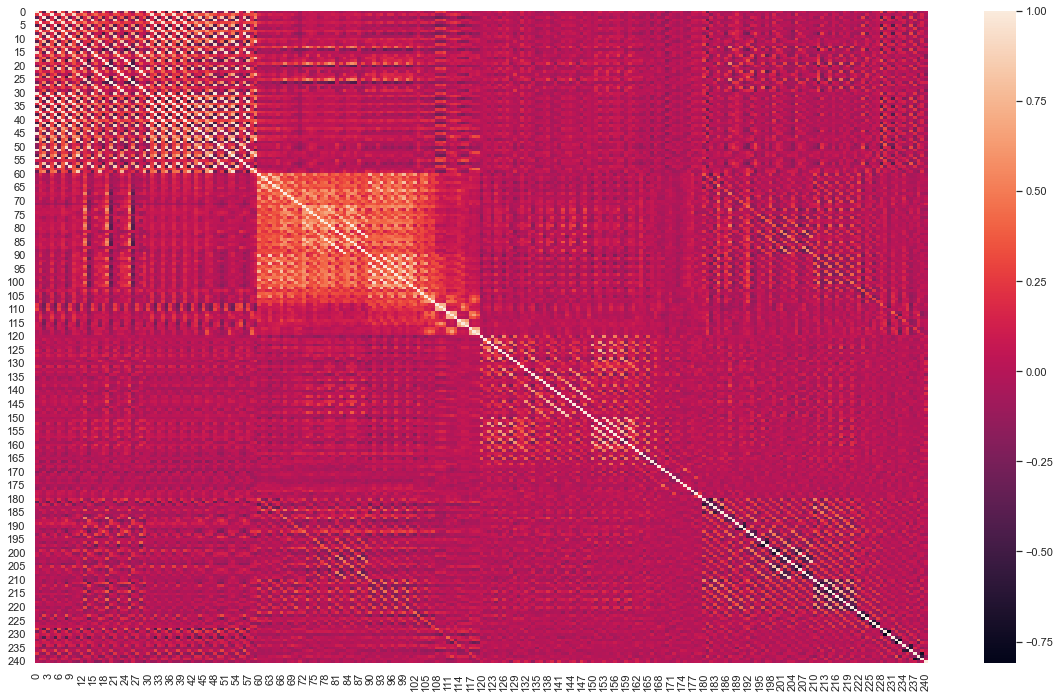

In [27]:
import seaborn as sns
sf_train = train.filter(rf_important_features[-40:], axis=1)
sf_test = test.filter(rf_important_features[-40:], axis=1)
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(train.corr())

In [9]:
cor_matrix = train.corr().abs()
print(cor_matrix)

          0         1         2         3         4         5         6    \
0    1.000000  0.241124  0.388192  0.993186  0.231913  0.430803  0.989078   
1    0.241124  1.000000  0.152672  0.256302  0.993519  0.149613  0.248765   
2    0.388192  0.152672  1.000000  0.371243  0.138642  0.975966  0.423677   
3    0.993186  0.256302  0.371243  1.000000  0.245181  0.404743  0.981177   
4    0.231913  0.993519  0.138642  0.245181  1.000000  0.136028  0.241319   
..        ...       ...       ...       ...       ...       ...       ...   
236  0.024088  0.070095  0.295258  0.012278  0.049267  0.301785  0.042467   
237  0.239861  0.119211  0.178457  0.214252  0.120554  0.224647  0.238458   
238  0.155206  0.027177  0.035208  0.121615  0.022199  0.071474  0.175418   
239  0.074362  0.152720  0.117749  0.072502  0.150525  0.125370  0.056781   
240  0.011444  0.040541  0.096792  0.019442  0.052237  0.104554  0.022052   

          7         8         9    ...       231       232       233  \
0  

In [10]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

     0         1         2         3         4         5         6    \
0    NaN  0.241124  0.388192  0.993186  0.231913  0.430803  0.989078   
1    NaN       NaN  0.152672  0.256302  0.993519  0.149613  0.248765   
2    NaN       NaN       NaN  0.371243  0.138642  0.975966  0.423677   
3    NaN       NaN       NaN       NaN  0.245181  0.404743  0.981177   
4    NaN       NaN       NaN       NaN       NaN  0.136028  0.241319   
..   ...       ...       ...       ...       ...       ...       ...   
236  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
237  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
238  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
239  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
240  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          7         8         9    ...       231       232       233  \
0    0.271182  0.295025  0.981433  ...  0.115108  0.134672  0.0

C:\Users\koutoua\AppData\Local\Temp\ipykernel_59164\3477284062.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [11]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


[3, 4, 5, 6, 9, 12, 15, 18, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 50, 51, 53, 54, 56, 57, 84, 85, 86, 87, 88, 89, 93, 94, 99]


In [12]:
train_drop = train.drop(train.columns[to_drop], axis=1)
train_drop

,0,1,2,7,8,10,11,13,14,16,...,231,232,233,234,235,236,237,238,239,240
0,-0.479730,0.726079,2.403713,0.406351,2.428461,0.434177,2.469511,0.157042,2.451617,0.322450,...,0.422235,0.730551,0.367526,0.520040,0.493564,0.485049,0.477886,0.607874,0.441320,5
1,0.051888,0.646871,2.409750,0.344324,2.461468,0.332072,2.433077,0.089980,2.475494,0.203840,...,0.365385,0.428723,0.571661,0.431776,0.279627,0.595978,0.389501,0.241849,0.617291,30
2,-0.002692,0.624926,2.240212,0.336314,2.305371,0.331344,2.240893,0.105647,2.369262,0.233975,...,0.449078,0.537268,0.488480,0.540547,0.542650,0.430114,0.542999,0.454954,0.479623,26
3,-0.029336,0.664426,2.443440,0.353489,2.506273,0.369529,2.410917,0.113854,2.551979,0.309557,...,0.420331,0.713397,0.387092,0.439498,0.417769,0.554555,0.498407,0.565789,0.455313,20
4,0.065604,0.639172,2.377587,0.339007,2.368022,0.347284,2.377467,0.172786,2.220435,0.187206,...,0.280299,0.671461,0.475014,0.401192,0.372539,0.578720,0.446630,0.580236,0.460550,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.153429,0.653027,2.290336,0.331688,2.247679,0.353553,2.450473,0.119903,2.097409,0.163334,...,0.417537,0.485318,0.522038,0.435164,0.464692,0.536148,0.538248,0.338490,0.536627,15
536,-0.270779,0.692372,2.418405,0.339803,2.340697,0.412317,2.626661,0.277535,2.141999,0.360223,...,0.266861,0.787530,0.375785,0.490460,0.512968,0.463116,0.507656,0.280617,0.563687,17
537,-0.293375,0.679736,2.413071,0.346635,2.347341,0.395454,2.628889,0.246916,2.175159,0.298622,...,0.384722,0.575436,0.505751,0.331261,0.389225,0.598488,0.617464,0.316425,0.504178,22
538,-0.497183,0.534425,2.322565,0.217394,2.218595,0.235550,2.470272,-0.022058,2.160863,0.053195,...,0.398216,0.759135,0.345677,0.341312,0.408758,0.589787,0.561659,0.399114,0.504443,19


In [13]:
test_drop = test.drop(test.columns[to_drop], axis=1)
test_drop

,0,1,2,7,8,10,11,13,14,16,...,231,232,233,234,235,236,237,238,239,240
0,-0.332255,0.672471,2.450465,0.370296,2.534973,0.380791,2.530804,0.181776,2.440313,0.209295,...,0.426959,0.604953,0.464157,0.751404,0.467516,0.306133,0.521694,0.546094,0.439480,28
1,-0.089784,0.656778,2.431880,0.349866,2.329680,0.382951,2.392629,0.218482,2.199293,0.312659,...,0.456633,0.596048,0.461552,0.557319,0.373754,0.515013,0.413323,0.491261,0.530069,13
2,-0.427810,0.699557,2.347763,0.402565,2.398841,0.475863,2.439914,0.161245,2.420894,0.592739,...,0.412314,0.777705,0.318174,0.532617,0.476989,0.487606,0.604556,0.489667,0.433812,1
3,-0.089790,0.694279,2.428455,0.404209,2.520148,0.452950,2.492525,0.142589,2.549358,0.523785,...,0.328799,0.551472,0.498960,0.313094,0.450005,0.581886,0.409794,0.377352,0.578679,1
4,-0.387741,0.540410,2.399926,0.262814,2.457772,0.232584,2.428738,0.017532,2.486053,0.053427,...,0.311284,0.684091,0.457543,0.446787,0.499285,0.512345,0.366741,0.468337,0.526775,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.120557,0.620886,2.150460,0.297987,2.067995,0.393044,2.350114,0.347971,1.826613,0.430931,...,0.546645,0.492502,0.471850,0.514066,0.456260,0.493552,0.644065,0.331046,0.482527,8
536,-0.286926,0.673395,2.408284,0.337695,2.390008,0.360159,2.548225,0.088812,2.380878,0.256313,...,0.346754,0.605193,0.495232,0.415223,0.503587,0.523376,0.540546,0.296970,0.549112,30
537,-0.067440,0.693735,2.366096,0.369984,2.308468,0.412408,2.527141,0.130460,2.282807,0.225305,...,0.420935,0.602493,0.465757,0.561188,0.402575,0.474175,0.498675,0.296885,0.563116,20
538,-0.316437,0.542775,2.278472,0.231794,2.184017,0.242041,2.420374,0.045852,2.070457,0.026526,...,0.409146,0.637756,0.438699,0.419514,0.405346,0.527979,0.323851,0.432784,0.583533,15


In [14]:
sf_test = test_drop
sf_train = train_drop

Decision Tree Classifier
Accuracy: 0.9537
Macro Precision: 0.9608
Macro Recall: 0.958
Macro F Score: 0.9568


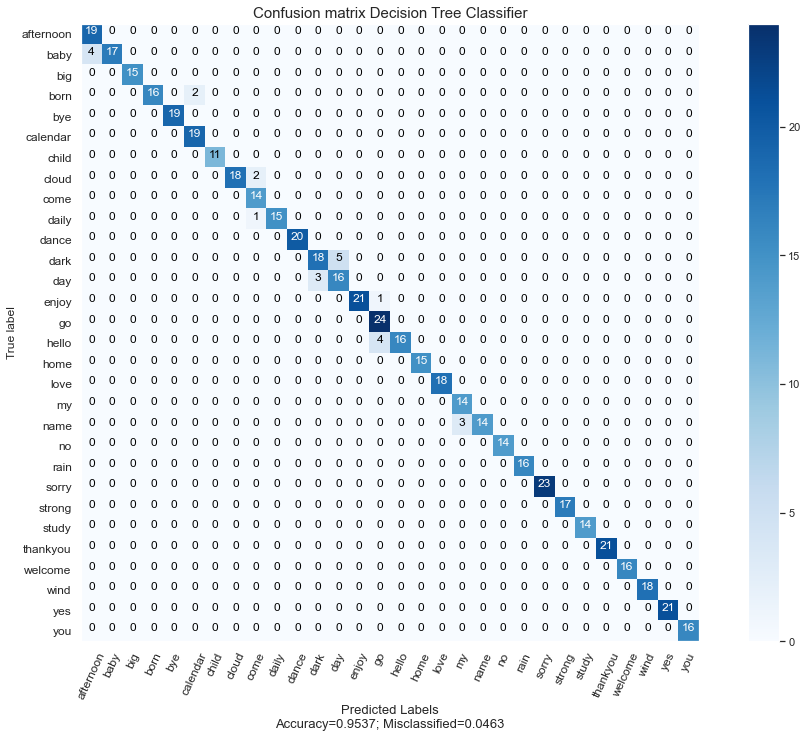

In [19]:
dtc_model = DecisionTreeClassifier(max_depth=100)
dtc_model.fit(sf_train ,target_train)
predictions = dtc_model.predict(sf_test)
plot_performance_results(dtc_model, "Decision Tree Classifier", predictions, target_test, sf_train, sf_test)

Random Forest Classifier
Accuracy: 0.9204
Macro Precision: 0.9276
Macro Recall: 0.9269
Macro F Score: 0.9196


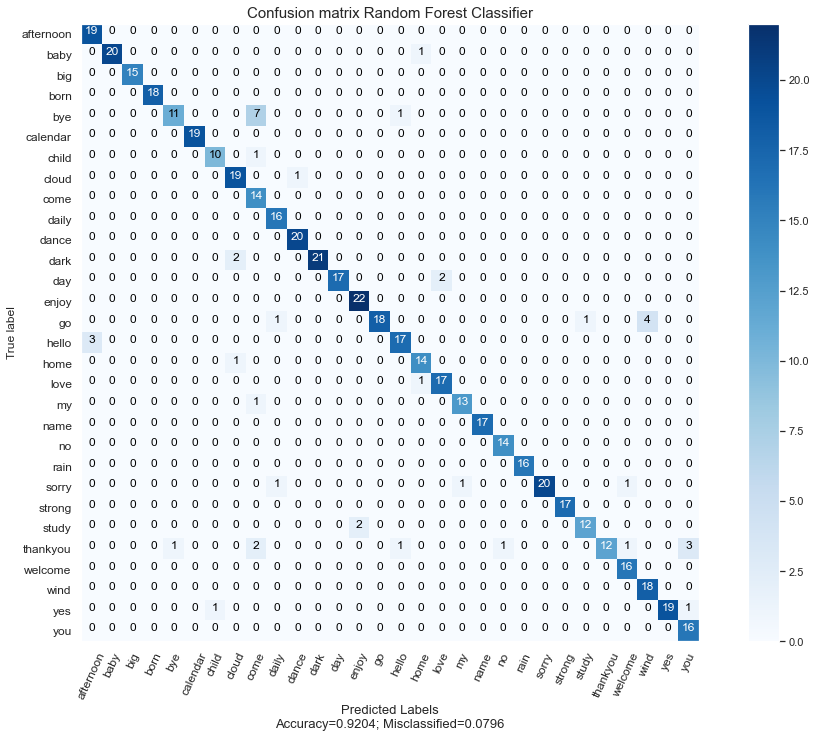

In [20]:
rfc_model = RandomForestClassifier(n_estimators=250,
                                max_features='auto',
                                n_jobs = 8,
                                random_state = 42)
rfc_model.fit(descriptive_train ,target_train)
predictions = rfc_model.predict(descriptive_test)
plot_performance_results(rfc_model, "Random Forest Classifier", predictions, target_test, descriptive_train, descriptive_test)

Multi-Layer Perceptron
Accuracy: 0.9611
Macro Precision: 0.9581
Macro Recall: 0.9557
Macro F Score: 0.9546


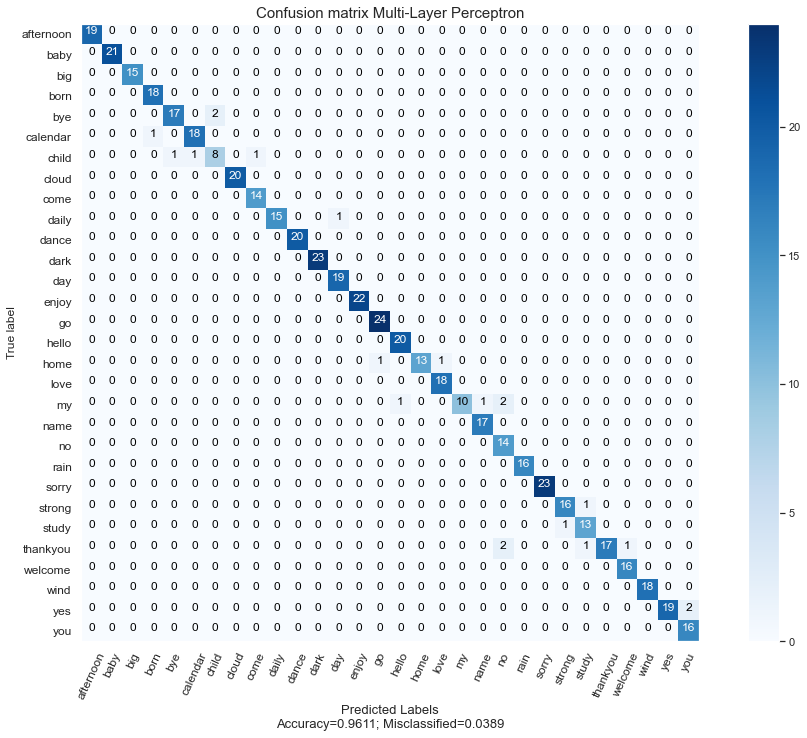

In [21]:
mlp_model =  MLPClassifier(max_iter=600, 
                           random_state=10, 
                           solver='adam',
                           learning_rate_init=0.001, 
                           hidden_layer_sizes=(160,),
                           activation='relu')
mlp_model.fit(sf_train ,target_train)
predictions = mlp_model.predict(sf_test)
plot_performance_results(mlp_model, "Multi-Layer Perceptron", predictions, target_test, sf_train, sf_test)

KNN Classifier
Accuracy: 0.9981
Macro Precision: 0.998
Macro Recall: 0.9984
Macro F Score: 0.9982


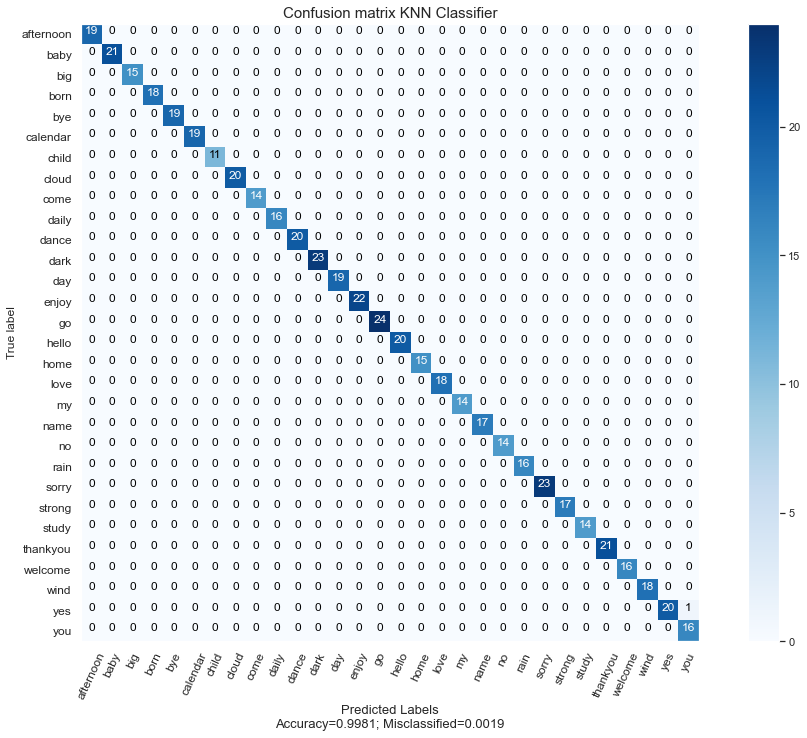

In [23]:
knn_model =  KNeighborsClassifier(n_neighbors=1)
knn_model.fit(sf_train ,target_train)
predictions = knn_model.predict(sf_test)
plot_performance_results(knn_model, "KNN Classifier", predictions, target_test, sf_train, sf_test)

SVM Classifier
Accuracy: 1.0
Macro Precision: 1.0
Macro Recall: 1.0
Macro F Score: 1.0


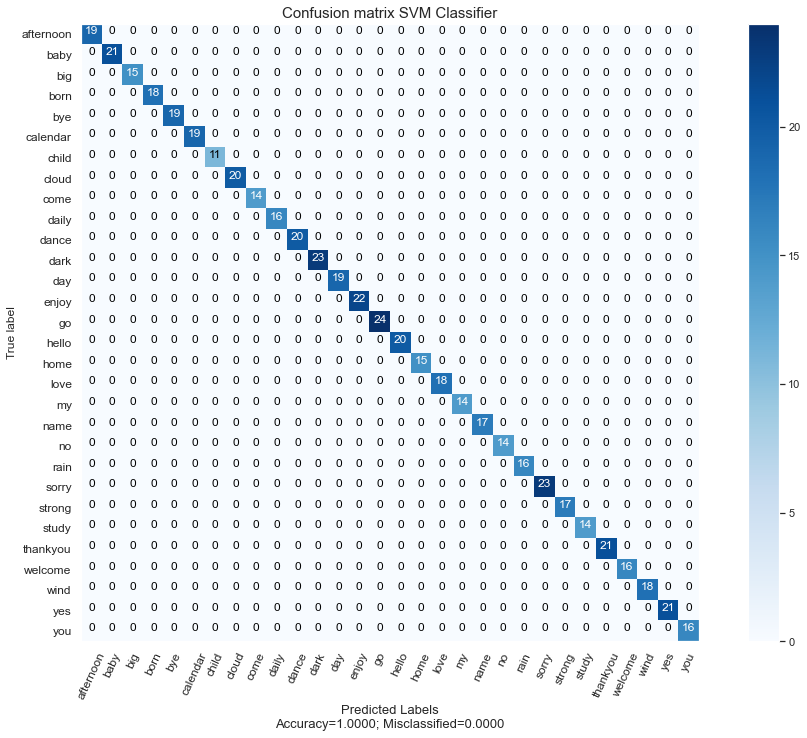

In [24]:
svm_model = svm.NuSVC(nu=0.2, decision_function_shape='ovo')
svm_model.fit(sf_train ,target_train)
predictions = svm_model.predict(sf_test)
plot_performance_results(svm_model, "SVM Classifier", predictions, target_test, sf_train, sf_test)

C:\Users\koutoua\Anaconda3\envs\ts_copy\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy: 0.9556
Macro Precision: 0.9528
Macro Recall: 0.9512
Macro F Score: 0.9496


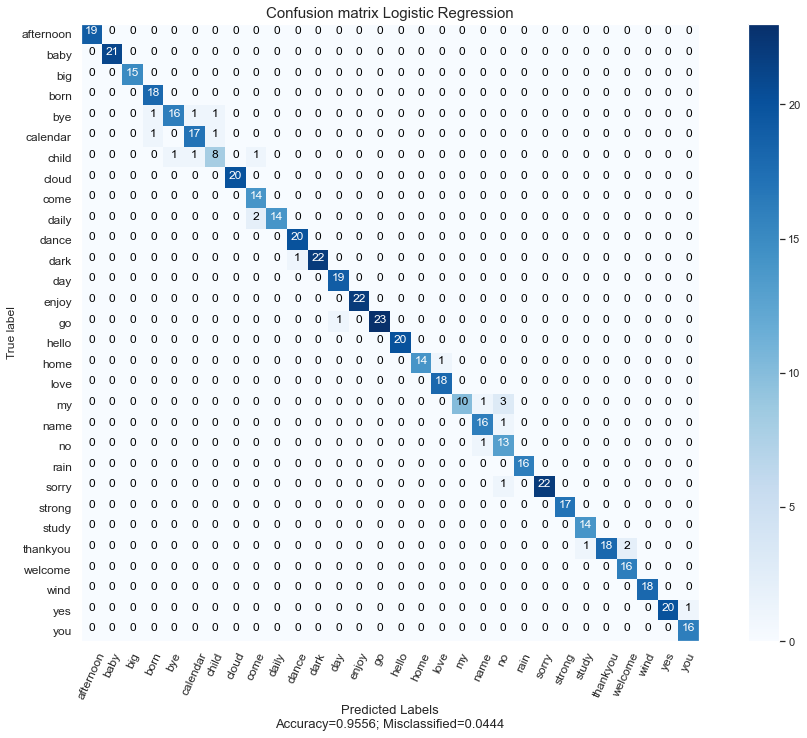

In [25]:
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(sf_train ,target_train)
predictions = lr_model.predict(sf_test)
plot_performance_results(lr_model, "Logistic Regression", predictions, target_test, sf_train, sf_test)